In [24]:
import pandas as pd 
import numpy as np
import normflows as nf
from sklearn.preprocessing import MinMaxScaler
import torch
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
training_data = pd.read_csv('fault_free_training.csv')
training_data.drop(['faultNumber', 'sample', 'Unnamed: 0'], axis=1, inplace=True)
training_data.rename(columns={'simulationRun': 'id'}, inplace=True)

X_train = training_data.drop(['id'], axis=1)
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train)
display(X_train)

del training_data # Running into RAM issues so doing a lot of del throughout the notebook

,xmeas_1,xmeas_2,xmeas_3,xmeas_4,xmeas_5,xmeas_6,xmeas_7,xmeas_8,xmeas_9,xmeas_10,...,xmv_2,xmv_3,xmv_4,xmv_5,xmv_6,xmv_7,xmv_8,xmv_9,xmv_10,xmv_11
0,0.475064,0.546864,0.553922,0.342491,0.502410,0.541063,0.479042,0.455087,0.588235,0.483488,...,0.409893,0.480777,0.628029,0.500000,0.463959,0.660638,0.554701,0.473079,0.500000,0.516351
1,0.477701,0.497640,0.633506,0.599260,0.412426,0.634461,0.489521,0.483248,0.588235,0.465426,...,0.327865,0.478160,0.314635,0.488903,0.481040,0.508478,0.346304,0.469467,0.518900,0.420388
2,0.475064,0.500674,0.406286,0.620658,0.494912,0.362856,0.507485,0.436177,0.647059,0.460226,...,0.562267,0.481118,0.506964,0.550879,0.485860,0.526080,0.500461,0.471251,0.488960,0.675883
3,0.472799,0.504046,0.505190,0.666887,0.432244,0.359098,0.522455,0.529291,0.470588,0.459314,...,0.460104,0.483355,0.371589,0.529313,0.486781,0.489019,0.543628,0.479521,0.572043,0.488933
4,0.637231,0.563722,0.461649,0.482631,0.502410,0.674181,0.491018,0.563001,0.470588,0.375296,...,0.388516,0.637749,0.453730,0.460218,0.407896,0.645781,0.548959,0.465941,0.546594,0.517424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249995,0.634260,0.432569,0.392445,0.293488,0.490627,0.528717,0.417665,0.592806,0.588235,0.504652,...,0.331593,0.654887,0.459073,0.373325,0.500532,0.327210,0.616016,0.507073,0.416542,0.540017
249996,0.627168,0.384019,0.488178,0.314622,0.502410,0.481481,0.423653,0.675437,0.470588,0.625433,...,0.431270,0.644498,0.530052,0.418970,0.664328,0.673637,0.723777,0.520044,0.439184,0.586276
249997,0.638457,0.298045,0.407728,0.294545,0.465453,0.565754,0.419162,0.422816,0.588235,0.674330,...,0.514044,0.633161,0.543312,0.363903,0.618045,0.557570,0.504101,0.522612,0.538735,0.585050
249998,0.483642,0.578894,0.431084,0.410118,0.662560,0.731616,0.375749,0.504008,0.470588,0.360427,...,0.337559,0.489573,0.534535,0.344012,0.421362,0.658660,0.342766,0.529097,0.233720,0.521330


In [3]:
X_train = np.array(X_train)
X_train

array([[0.47506406, 0.54686446, 0.55392157, ..., 0.47307943, 0.5       ,
        0.51635138],
       [0.47770062, 0.49763992, 0.63350634, ..., 0.46946681, 0.5188997 ,
        0.42038753],
       [0.47506406, 0.50067431, 0.40628604, ..., 0.47125136, 0.48895958,
        0.67588267],
       ...,
       [0.63845668, 0.2980445 , 0.4077278 , ..., 0.52261153, 0.53873503,
        0.58505016],
       [0.48364217, 0.57889413, 0.4310842 , ..., 0.52909684, 0.23372006,
        0.52132956],
       [0.48159976, 0.45987862, 0.37745098, ..., 0.53253536, 0.46594311,
        0.34104312]])

In [4]:
# Much of this code comes from the example at https://github.com/VincentStimper/normalizing-flows

# Set up model

# Define 2D Gaussian base distribution
base = nf.distributions.base.DiagGaussian(X_train.shape[1])

# Define list of flows
num_layers = 16
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([math.floor(X_train.shape[1]/2), 64, 64, X_train.shape[1]], init_zeros=True)
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))
    
# Construct flow model
model = nf.NormalizingFlow(base, flows)
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

 20%|███████████████▋                                                               | 498/2500 [00:35<02:18, 14.51it/s]

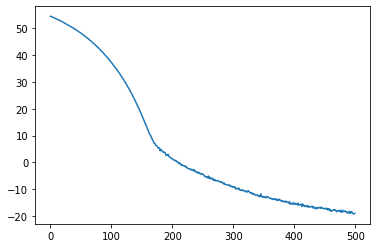

 40%|███████████████████████████████▌                                               | 998/2500 [01:11<01:49, 13.71it/s]

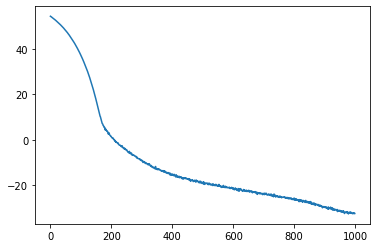

 60%|██████████████████████████████████████████████▋                               | 1498/2500 [01:47<01:19, 12.65it/s]

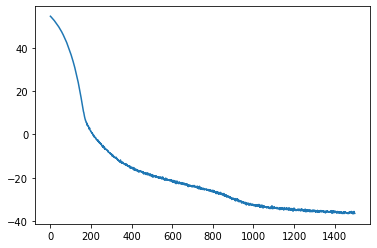

 80%|██████████████████████████████████████████████████████████████▎               | 1998/2500 [02:23<00:37, 13.32it/s]

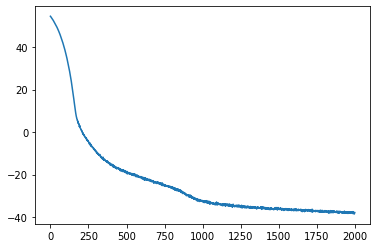

100%|█████████████████████████████████████████████████████████████████████████████▉| 2498/2500 [03:00<00:00, 11.43it/s]

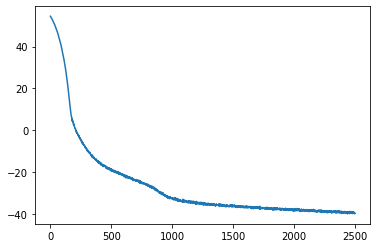

100%|██████████████████████████████████████████████████████████████████████████████| 2500/2500 [03:00<00:00, 13.82it/s]


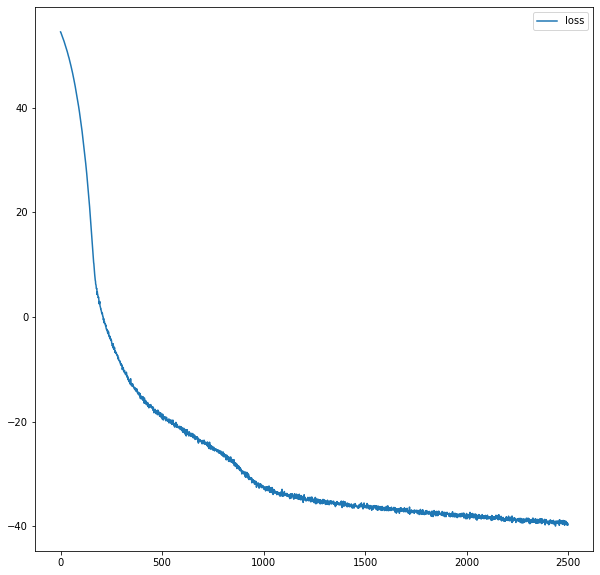

In [5]:
# Train model
max_iter = 2500
num_samples = 2 ** 9
show_iter = 500


loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=4e-5, weight_decay=1e-5)

for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    # Should probably not operate on whole dataset at once - just sample from it
    sample_indices = np.random.choice(range(X_train.shape[0]), num_samples, replace=False)
    x = torch.tensor(X_train[sample_indices,:]).float().to(device)
    
    # Compute loss
    loss = model.forward_kld(x)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
        
    # Do marginal likelihood steps here too--

    # --
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    
    # Plot loss so far
    if (it + 1) % show_iter == 0:
        plt.plot(loss_hist)
        plt.show()

# Plot overall loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

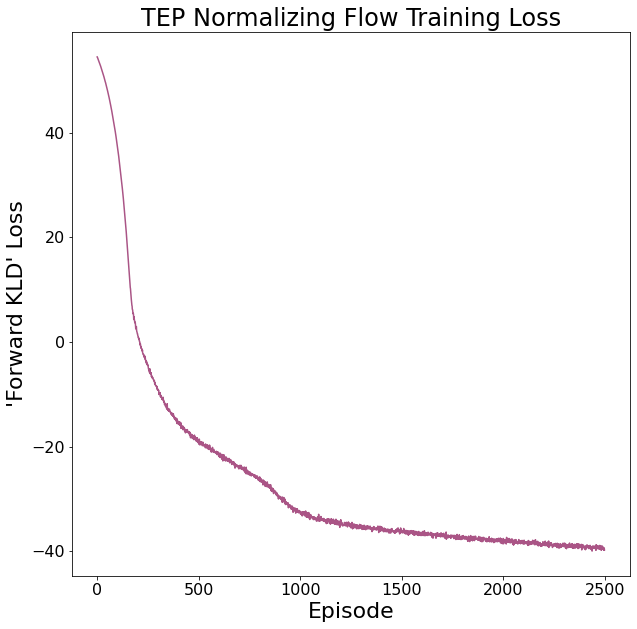

In [6]:
plt.figure(figsize=(10, 10))
plt.title("TEP Normalizing Flow Training Loss", fontsize="24")
plt.xlabel("Episode", fontsize="22")
plt.ylabel("'Forward KLD' Loss", fontsize="22")
plt.plot(loss_hist, label='loss', color="#AA5586")
plt.xticks(fontsize="16")
plt.yticks(fontsize="16")
# plt.savefig('./figures/nf_train_loss.png')
plt.show()

In [8]:
print(loss)

tensor(-39.7410, grad_fn=<NegBackward0>)


In [9]:
model.eval()
# Gather training predicted log probabilities
log_prob = model.log_prob(torch.tensor(X_train).float().to(device))
model.train()
prob = torch.exp(log_prob)

In [10]:
prob = prob.detach().numpy()

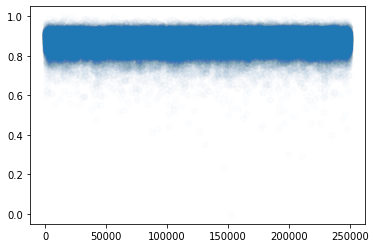

In [11]:
prob_scaler = MinMaxScaler()
# Scale the log probabilities
scaled_train_probs = prob_scaler.fit_transform(np.log(prob).reshape(-1, 1))

plt.scatter(range(len(prob)), scaled_train_probs, alpha=0.01)

In [12]:
# Threshold according to the equation in our report
threshold = np.median(scaled_train_probs) - 3 * np.std(scaled_train_probs)

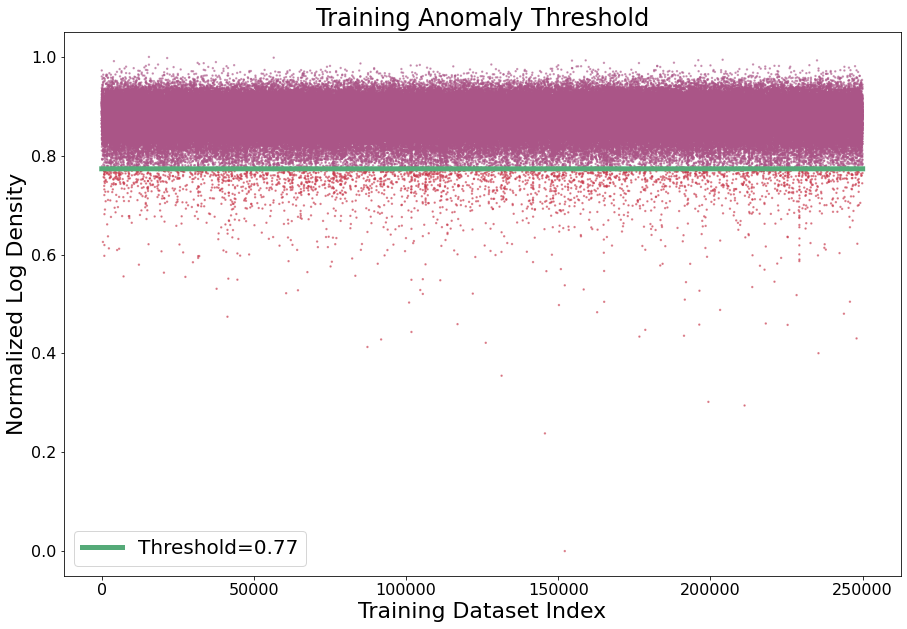

In [13]:
col = np.where(scaled_train_probs < threshold, '#C8374A', '#AA5587').squeeze()

plt.figure(figsize=(15,10))
plt.title("Training Anomaly Threshold", fontsize="24")
plt.plot(range(len(prob)), [threshold]*len(prob), color="#55AA78", label="Threshold=%0.2f" % threshold, linewidth=5)
plt.scatter(range(len(prob)), scaled_train_probs, alpha=0.5, c=col, s=2)
plt.xlabel("Training Dataset Index", fontsize="22")
plt.ylabel("Normalized Log Density", fontsize="22")
plt.xticks(fontsize="16")
plt.yticks(fontsize="16")
plt.legend(fontsize="20")
# plt.savefig('./figures/training_density.png')
plt.show()

In [14]:
threshold

0.7735739797353745

(array([1.00000e+00, 0.00000e+00, 2.00000e+00, 2.00000e+00, 1.80000e+01,
        6.00000e+01, 3.91000e+02, 6.59300e+03, 1.84082e+05, 5.88510e+04]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

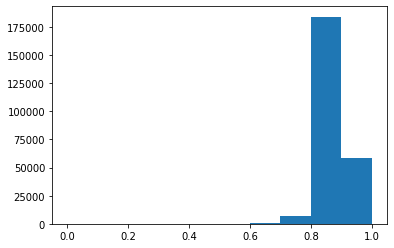

In [15]:
plt.hist(scaled_train_probs)

In [16]:
FP_train = np.count_nonzero(scaled_train_probs < threshold)

In [17]:
# False alarm rate
print(FP_train / len(scaled_train_probs))

0.012064


In [27]:
# Function to predict which points are anomalies
def predict_anomalies(model, data, scaler, prob_scaler, threshold, training=False):
    
    if not training:
        category = data['faultNumber']
        data['faultNumber'] = data['sample'] > 20 # Faults were introduced one hour in (20 samples)
        faults = data['faultNumber']
    else:
        category = 0
        faults = [0] * len(data['faultNumber'])
    data.drop(['faultNumber', 'sample', 'Unnamed: 0'], axis=1, inplace=True)
    data.rename(columns={'simulationRun': 'id'}, inplace=True)
    
    data = data.drop(['id'], axis=1)
    data = np.array(data)
    data = scaler.transform(data)
    
    model.eval()
    test_probs = np.nan_to_num(model.log_prob(torch.tensor(data).float().to(device)).detach().numpy(), nan=-9999, neginf=-9999)
    test_probs = prob_scaler.transform(test_probs.reshape(-1,1))

    anom_preds = test_probs < threshold
    
    return faults, anom_preds.tolist(), test_probs.tolist(), category

In [20]:
# Predicts which faulty points are faults
y = []
yhat = []
anomaly_probs = []
categories = []

with pd.read_csv('faulty_training.csv', chunksize=100000) as reader:
    for chunk in reader:
        print("Chunk started")
        curr_y, curr_yhat, curr_probs, curr_categories = predict_anomalies(model, chunk, scaler, prob_scaler, threshold)
        y.extend(curr_y)
        yhat.extend(curr_yhat)
        anomaly_probs.extend(curr_probs)
        categories.extend(curr_categories)
        
yhat = np.array(yhat).squeeze()
anomaly_probs = np.array(anomaly_probs).squeeze()

Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [21]:
# Determines the fault detection rate for each category
category_correct = [0]*len(set(categories))
for i in range(len(categories)):
    if yhat[i] == y[i] and y[i] > 0:
        category_correct[categories[i]-1] += 1
    
category_acc = np.array(category_correct) / (len(categories)/len(category_correct))
category_acc

array([0.954836, 0.938496, 0.011192, 0.958632, 0.958776, 0.96    ,
       0.96    , 0.914932, 0.012736, 0.47636 , 0.6822  , 0.939732,
       0.874672, 0.958256, 0.013732, 0.76424 , 0.738592, 0.832484,
       0.571892, 0.630396])

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

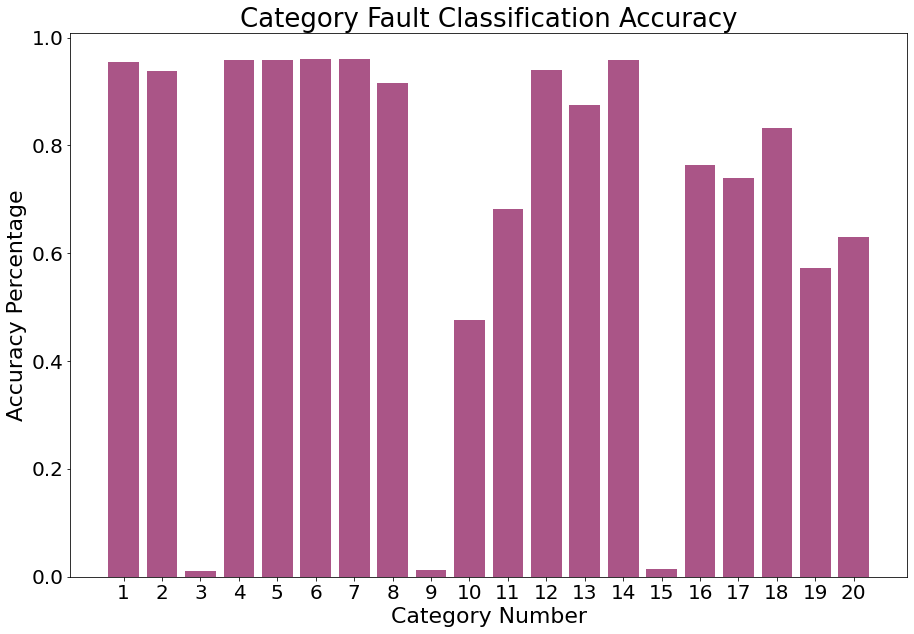

In [22]:
plt.figure(figsize=(15,10))
plt.title("Category Fault Classification Accuracy", fontsize="26")
plt.bar(list(range(1, len(category_correct)+1)), category_acc, color="#AA5587")
plt.ylabel("Accuracy Percentage", fontsize="22")
plt.xlabel("Category Number", fontsize="22")
plt.xticks(list(range(1, len(category_correct)+1)), fontsize="20")
plt.yticks(fontsize="20")
# plt.savefig('./figures/fault_categories.png')

In [25]:
metrics.accuracy_score(y,yhat)

0.7474958

In [28]:
# Predicts fault free training data
y_train = []
yhat_train = []
anomaly_probs_train = []

with pd.read_csv('fault_free_testing.csv', chunksize=100000) as reader:
    for chunk in reader:
        print("Chunk started")
        curr_y, curr_yhat, curr_probs, _ = predict_anomalies(model, chunk, scaler, prob_scaler, threshold, training=True)
        y_train.extend(curr_y)
        yhat_train.extend(curr_yhat)
        anomaly_probs_train.extend(curr_probs)
        
yhat_train = np.array(yhat_train).squeeze()
anomaly_probs_train = np.array(anomaly_probs_train).squeeze()
# Is this necessary?
anomaly_probs_train = np.clip(anomaly_probs_train, 0, 1)

Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Chunk started


C:\Users\austi\miniconda3\envs\aml\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [29]:
metrics.accuracy_score(y_train,yhat_train)

0.9868354166666666

In [30]:
# Combine the two:
y.extend(y_train)
yhat = yhat.tolist()
yhat.extend(yhat_train.tolist())
anomaly_probs = anomaly_probs.tolist()
anomaly_probs.extend(anomaly_probs_train.tolist())

metrics.accuracy_score(y,yhat)

0.7684598540145985

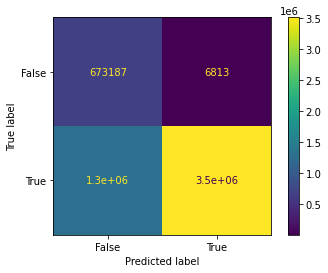

In [109]:
metrics.ConfusionMatrixDisplay.from_predictions(y, yhat)